##### Visualize Mixing Depth and PAR over full hindcast <br>
G Oldford
Apr 2023

Purpose: generate hovmollers and climatological profile along N-S (maybe thalweg)
         and trends of mixing layer depth and photosynthetically available radiation 
         
Data in: mixing layer depth (monthly, either NC or ASC, clipped to ECOSPACE - opting for ASCs here)

Code based on work by Tereza Jarnikova to generate the figs and analysis for temp, salin

Notes: 2023-04-03 - missing mixing data for 2018

In [187]:
import numpy as np
import xarray as xr
import pandas as pd


## Load data as-is into xarray dataset and then row-wise avg as xr

path_data = "../data/output/RUN203/ECOSPACE/"
mxng_p = "NEMO_prepped_as_ASC/{var}/"
li_p = "ECOSPACE_in_PAR3/{var}/"

# template file names w/ var names
v_f = {"MixedLyrZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc", 
       "MixingTurboZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc", 
       "PAR-VarZ-VarK":path_data + li_p + "{var}_{year}_{month}.asc"}

yr_strt = 1979
yr_end = 2017
months_d = {"01": 1, "02": 2, "03": 3,"04": 4,"05": 5,"06": 6,"07": 7,"08": 8,"09": 9,"10": 10,"11": 11,"12": 12}
months = list(range(1,12))

rows = 151
cols = 93
months = 12

skiprows = 6

time = pd.date_range(start='{yr_strt}-01-01'.format(yr_strt=yr_strt), 
                              end='{yr_end}-12-01'.format(yr_end=yr_end), 
                              freq='MS')+ pd.DateOffset(days=14)

# empty ds for all 
ds = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), # watch if zero indexing
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# create empty variable with correct shape
for v in v_f:
    ds[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows, cols)),
        dims=('time', 'row', 'col'),
        attrs={'description': f'{v} data'}
    )

# load the data
for v in v_f:
    attribute = v_f[v]
    for y in range(yr_strt, yr_end+1):
        for m in sorted(months_d.keys()):
            f_n = v_f[v].format(var=v,year=y,month=m)
            with open(f_n) as f:
                data = np.loadtxt(f,skiprows=skiprows)
                
                # replace
                data[data==-9999.0]=['nan']
                data[data==0.0]=['nan']
                
                ds[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    data,
                    dims=('row', 'col'),
                    attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
                
# second dataset to store the row-wise averages 
ds2 = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# empty variable with correct shape for ds2
for v in v_f:
    ds2[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows)),
        dims=('time','row'),
        attrs={'description': f'{v} avg row-wise'}
    )
    
# Calculates row-wise averages for each attribute and each month
for v in v_f:
    for y in range(yr_strt, yr_end+1):   
        for m in sorted(months_d.keys()):
            # Select the data for this attribute and month
            data = ds[v].sel(time=f'{y}-{m}'.format(y=y,m=m))

            # Calculate the row-wise average and print it
            row_avg = data.mean(dim='col')
            
            ds2[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    row_avg[0],
                    dims=('row'),
                    attrs={'description': f'{v} avg row-wise data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
            

In [188]:
ds2

<xarray.Dataset>
Dimensions:        (time: 468, row: 151)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2017-12-15
  * row            (row) int32 1 2 3 4 5 6 7 8 ... 145 146 147 148 149 150 151
Data variables:
    MixedLyrZ      (time, row) float64 12.81 12.37 12.82 ... 16.17 15.98 16.57
    MixingTurboZ   (time, row) float64 13.35 13.2 13.44 ... 30.75 29.39 29.73
    PAR-VarZ-VarK  (time, row) float64 9.1 9.326 9.258 ... 7.243 7.078 6.489
Attributes:
    description:  Example dataset of monthly ASC files

In [189]:
import cartopy as cp
import matplotlib.pyplot as plt
import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm



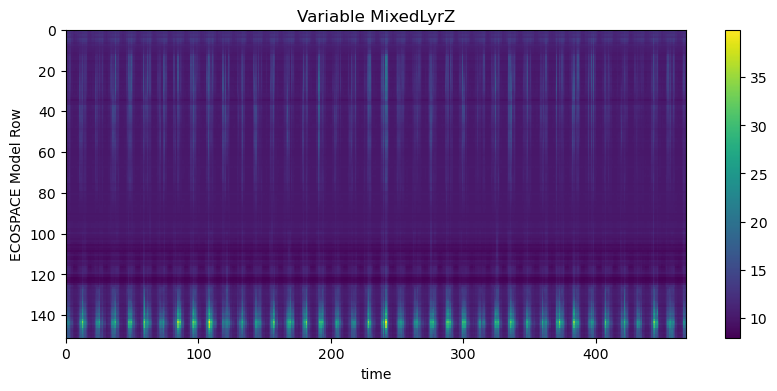

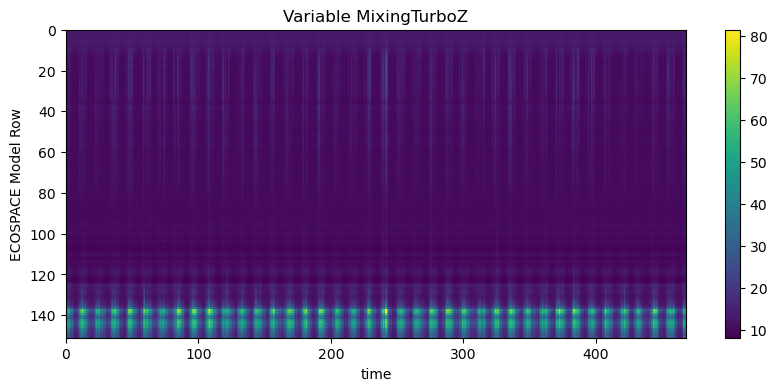

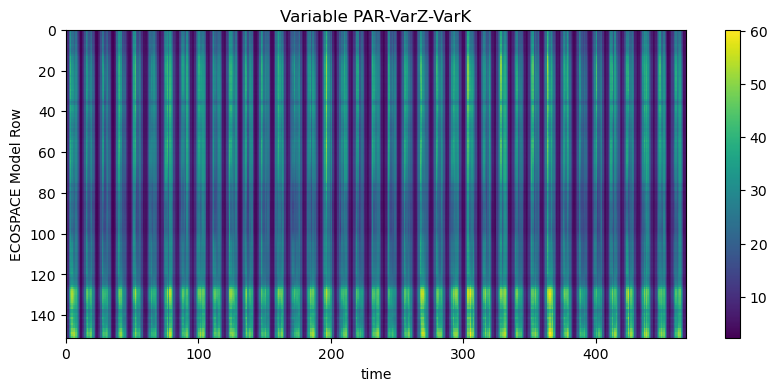

In [211]:


for v in v_f:
    v1 = ds2[v]
    fig, axs = plt.subplots(figsize = (10,4))
    w = plt.pcolormesh(xr.DataArray.transpose(v1))
    axs.set_title('Variable {v}'.format(v=v))
    plt.colorbar(w, ax = axs)
    axs.invert_yaxis()
    axs.set_xlabel('time')
    axs.set_ylabel('ECOSPACE Model Row')




Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

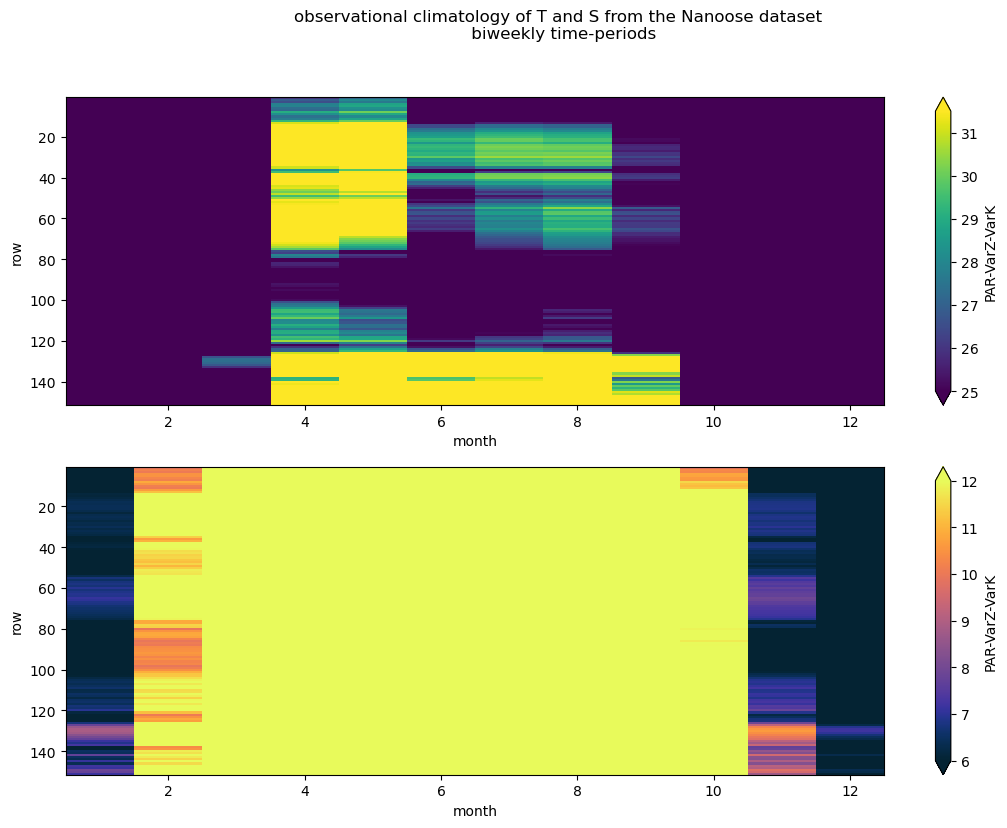

In [228]:
q = v1.groupby('time.month').mean(dim='time').T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#salt_clim = ds.salinity.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(q, ax = axs[0], vmin = 25, vmax = 31.5)
#xr.plot.pcolormesh(q, ax = axs[0], vmin = 25, vmax = 31.5)

#temp_clim = ds.temperature.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(q, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')


In [222]:
v1.groupby(v1.row).mean('time',).T

ValueError: cannot reduce over dimensions ['time.month']. expected either '...' to reduce over all dimensions or one or more of ('time',).

<xarray.DataArray 'PAR-VarZ-VarK' (month: 12, row: 151)>
array([[ 4.96410256,  5.10858417,  5.03643725, ...,  7.86234432,
         7.74303534,  7.15538462],
       [ 9.91117949, 10.17792642, 10.03265857, ..., 14.31692308,
        14.16936937, 13.08415954],
       [17.03723077, 17.48807135, 17.22645074, ..., 24.23699634,
        23.87380457, 21.99156695],
       ...,
       [ 9.88666667, 10.32909699, 10.2585695 , ..., 21.44095238,
        21.12772003, 19.40193732],
       [ 4.84810256,  5.02140468,  4.96356275, ...,  9.73824176,
         9.55398475,  8.75002849],
       [ 3.56697436,  3.67346711,  3.61619433, ...,  6.33655678,
         6.27040887,  5.7811396 ]])
Coordinates:
  * row      (row) int32 1 2 3 4 5 6 7 8 9 ... 144 145 146 147 148 149 150 151
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12